In [45]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [1]:
from transformers import (AutoModelForSequenceClassification, pipeline)
import transformers
import datasets
from tqdm import tqdm
# from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request
import pandas as pd
from tqdm import tqdm
from typing import Callable
from collections.abc import Iterable
import time
import seaborn as sns

/Users/elliotheisler/anaconda3/envs/cmpt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
TASK='sentiment-analysis'
MODEL = f"cardiffnlp/twitter-roberta-base"
# pipe = pipeline(task=TASK, model=MODEL)
tokenizer = AutoTokenizer.from_pretrained(MODEL, force_download=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

In [ ]:
# TODO: run the model
tm = time.time()
df['user_review'] = df['user_review'].fillna('').astype('string')
t = list(df['user_review'][980:1000].map(lambda t: t[:240]))
t = tokenizer(t, return_tensors='pt', padding=True)
t = model(**t)
t = softmax(t.logits.detach(), axis=1)
print(time.time() - tm)

### format dataframes

In [5]:
def format_reviews_df(df: pd.DataFrame): 
    df = df.copy()
    df['user_review'] = df['user_review'].fillna('').astype('string')
    df['title'] = df['title'].fillna('').astype('string')
    return df

def format_games_df(df: pd.DataFrame): 
    df = df.copy()
    df = df.astype({'title': 'string', 'developer': 'string',
               'publisher': 'string', 'tags': 'string',
               'overview': 'string'
              })
    return df
    
df = pd.read_csv('data/new_df.csv')
df = format_reviews_df(df)

df_games = pd.read_csv('data/train_gr/game_overview.csv')
df_games = format_games_df(df_games)

### merge game info columns from game_overview.csv

In [6]:
new_df = df.join(df_games.set_index('title'), on='title', lsuffix='_l', rsuffix='_r', validate='m:1')
new_df.tail(2)

,review_id,title,year,user_review,user_suggestion,is_early_access,received_free,contains_art,developer,publisher,tags,overview
17314,25536,EverQuest II,2017.0,"An older game, to be sure, but has its own cha...",1,False,False,False,Daybreak Game Company,Daybreak Game Company,"['Free to Play', 'Massively Multiplayer', 'RPG...",EverQuest® II is the epitome of massively mult...
17315,25537,EverQuest II,2011.0,When I frist started playing Everquest 2 it wa...,1,False,False,False,Daybreak Game Company,Daybreak Game Company,"['Free to Play', 'Massively Multiplayer', 'RPG...",EverQuest® II is the epitome of massively mult...


### prepare input

In [46]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
le = LabelEncoder()
oe = OrdinalEncoder().set_output(transform="pandas")

numeric_df = new_df.copy()
numeric_df = numeric_df.drop(['review_id', 'tags', 'overview', 'user_review'], axis=1) # TODO: add sentiment scores
# fit transforms for y and x
numeric_df['user_suggestion'] = le.fit_transform(numeric_df['user_suggestion'])
# x: string enums
numeric_df[['title', 'developer', 'publisher']] = \
    oe.fit_transform(numeric_df[['title', 'developer', 'publisher']])
# x: bools
numeric_df[['is_early_access', 'received_free', 'contains_art']] = \
    oe.fit_transform(numeric_df[['is_early_access', 'received_free', 'contains_art']])

### correlation matrix

<Axes: >

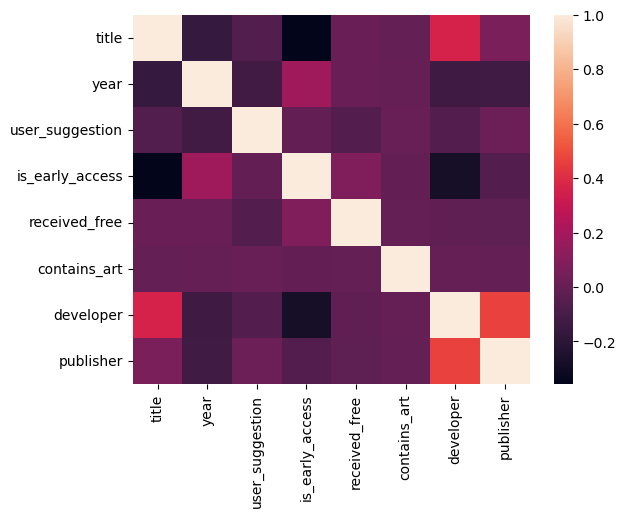

In [41]:
sns.heatmap(numeric_df.corr())

### x and y, selkbest, and standard scaler

In [50]:
# x and y
y = numeric_df['user_suggestion']
x = numeric_df.drop('user_suggestion', axis=1)

In [58]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, r_regression
from sklearn.model_selection import train_test_split
# selkbest
skb = SelectKBest(score_func=chi2, k=5).set_output(transform='pandas')
best_x = skb.fit_transform(x, y)
# scaled
scaler = StandardScaler()
scaled_x = scaler.fit_transform(best_x)
scaled_x = pd.DataFrame(scaled_x, columns=best_x.columns)

x_train, x_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.20)

### SVM

In [59]:
from sklearn.svm import SVC
svm_classifier = SVC()
svm_classifier.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [60]:
svm_classifier.fit(x_train, y_train)

SVC()

In [64]:
y_pred = svm_classifier.predict(x_test)

<Axes: >

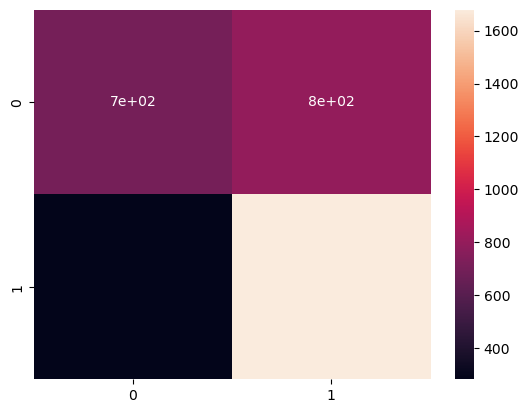

In [69]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True)